In [1]:
import torch
from trainer import *
from torch.utils.data import DataLoader
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from models.CNN import StrainEnergyCANN_Ani, CANN_CombinedModel, PsiModel
from sklearn.metrics import r2_score
from typing import Optional

# Предобработка данных

In [52]:
import pandas as pd 
from utils.dataload import BrainDataset

all_data_path = r'C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\data\brain_bade/CANNsBRAINdata.xlsx'
xls = pd.ExcelFile(all_data_path)

# Load the first sheet
df_sheet1 = pd.read_excel(xls, sheet_name='Sheet1')

# Clean the first sheet by removing unnecessary rows and renaming columns
df_sheet1_cleaned = df_sheet1.iloc[3:].reset_index(drop=True)

# Keep only the relevant columns and rename them
relevant_columns = df_sheet1_cleaned.iloc[:, :4]
relevant_columns.columns = ['stretch', 'stress_ut', 'gamma', 'stress_ss']
brain_data = relevant_columns

weight_u_value = 0.5
weight_t_value = 0.5
weight_ss_value = 1.

brain_data['weight_ut'] = [weight_u_value] * (len(brain_data) // 2) + [weight_t_value] * (len(brain_data) - len(brain_data) // 2)
brain_data['weight_ss'] = weight_ss_value

dataset = BrainDataset(brain_data)

print(dataset.data.columns)
print(dataset[10])

train_data_loader = DataLoader(
                        dataset,
                        shuffle=True,
                        # num_workers=1,
                        pin_memory=False, 
                        batch_size=2
)
test_data_loader = DataLoader(
                        dataset,
                        shuffle=False,
                        # num_workers=1,
                        pin_memory=False
)

Index(['stretch', 'stress_ut', 'gamma', 'stress_ss', 'weight_ut', 'weight_ss'], dtype='object')
(tensor(0.9625), tensor(-0.0750), tensor(-0.2375), tensor(-0.0983), tensor(0.5000), tensor(1.))


# Обучение модели

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import ast

def plot_results(df):
    # df['stress_ut_model'] = df['stress_ut_model'].apply(lambda x: ast.literal_eval(x)[0])
    # df['stress_ss_model'] = df['stress_ss_model'].apply(lambda x: ast.literal_eval(x)[0])
    tensile_start_index = len(df) // 2
    stretch_compression = df["stretch"][:tensile_start_index]
    stretch_tensile = df["stretch"][tensile_start_index:]

    stress_compression = df["stress_ut"][:tensile_start_index]
    stress_tensile = df["stress_ut"][tensile_start_index:]

    stress_model_compression = df["stress_ut_model"][:tensile_start_index]
    stress_model_tensile = df["stress_ut_model"][tensile_start_index:]
    
    # Calculate R2 scores
    r2_u_model = r2_score(stress_compression, stress_model_compression)
    r2_t_model = r2_score(stress_tensile, stress_model_tensile)
    r2_ss_model = r2_score(df['stress_ss'], df['stress_ss_model'])
    
    # Plot graphs
    plt.figure(figsize=(14, 6))
    
    # Plot for stress_ut and stress_ut_model
    plt.subplot(1, 3, 1)
    plt.plot(stretch_tensile, stress_model_tensile, "s-", color="orange",  label=r"$\mathbb{P}_{model}$")
    plt.scatter(stretch_tensile, stress_tensile, label=r"$\mathbb{P}$")
    plt.title(f'Тест на одноосное растяжение (R² = {r2_t_model:.2f})')
    plt.xlabel('Удлинение')
    plt.ylabel('Напряжение, кПа')
    plt.grid()
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(stretch_compression[:], stress_model_compression, "s-", color="orange", label=r"$\mathbb{P}_{model}$")
    plt.scatter(stretch_compression[:], stress_compression,  label=r"$\mathbb{P}$")
    plt.title(f'Тест на сжатие (R² = {r2_u_model:.2f})')
    plt.xlabel('Удлинение')
    plt.ylabel('Напряжение, кПа')
    plt.grid()
    plt.legend()
    
    # Plot for stress_ss and stress_ss_model
    plt.subplot(1, 3, 3)
    plt.scatter(df['gamma'], df['stress_ss'],  label=r"$\mathbb{P}$")
    plt.plot(df['gamma'], df['stress_ss_model'], "s-", color="orange", label=r"$\mathbb{P}_{model}$")
    plt.title(f'Тест на сдвиг (R² = {r2_ss_model:.2f})')
    plt.xlabel('Сдвиг')
    plt.ylabel('Напряжение, кПа')
    plt.legend()

    plt.grid()
    plt.tight_layout()
    plt.show()

    return r2_u_model, r2_u_model, r2_ss_model


----------------------------------------------------------------------
Directory pretrained_models\brain_CANN_CombinedModel already exists
Epoch [1/10000], Loss: 1204.22367893, Test metric: 1204.22367893
psi =   1.159148 * (I1 - 3) \\                 + 0.976716 * (e^{  4.057528 * (I1 - 3)} - 1)\\                 - 2.160519 * ln(1 - 4.159323 * (I1 - 3)) \\                 + 3.202020 * (I1 - 3) ^ 2 \\                 + 1.777991 * (e^{  2.158016 * (I1 - 3) ^ 2} - 1)\\                 - 1.744233 * ln(1 - 0.763225 * (I1 - 3) ^ 2) \\                                   + 3.052192 * (I2 - 3) \\                 + 0.814282 * (e^{  4.235946 * (I2 - 3))} - 1)\\                 - 2.049365 * ln(1 - 4.275278 *  (I2 - 3)) \\                 + 8.830846 * (I2 - 3) ^ 2 \\                 + 0.548541 * (e^{ 4.562754 *(I2 - 3) ^ 2)} - 1)\\                 - 3.532405 * ln(1 -4.471317 * (I2 - 3) ^ 2)\\
Epoch [1/10000], Loss: 1204.22367893, Test metric: 1204.22367893
--------------------------------------------

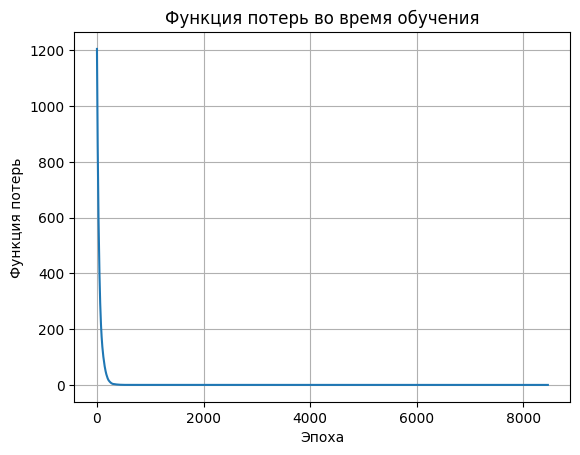

Saved PyTorch Model State to pretrained_models\brain_CANN_CombinedModel\20240625_1421_5461.pth
 0.000000 * (I1 - 3) \\                 + 0.000000 * (e^{  0.000000 * (I1 - 3)} - 1)\\                 - 0.000000 * ln(1 - 0.000000 * (I1 - 3)) \\                 + 0.000000 * (I1 - 3) ^ 2 \\                 + 0.000000 * (e^{  2.158016 * (I1 - 3) ^ 2} - 1)\\                 - 0.000000 * ln(1 - 0.763225 * (I1 - 3) ^ 2) \\                                   + 0.000000 * (I2 - 3) \\                 + 0.000000 * (e^{  0.000000 * (I2 - 3))} - 1)\\                 - 0.011079 * ln(1 - 2.182927 *  (I2 - 3)) \\                 + 8.307529 * (I2 - 3) ^ 2 \\                 + 1.417893 * (e^{ 4.562754 *(I2 - 3) ^ 2)} - 1)\\                 - 0.257239 * ln(1 -4.471317 * (I2 - 3) ^ 2)\\


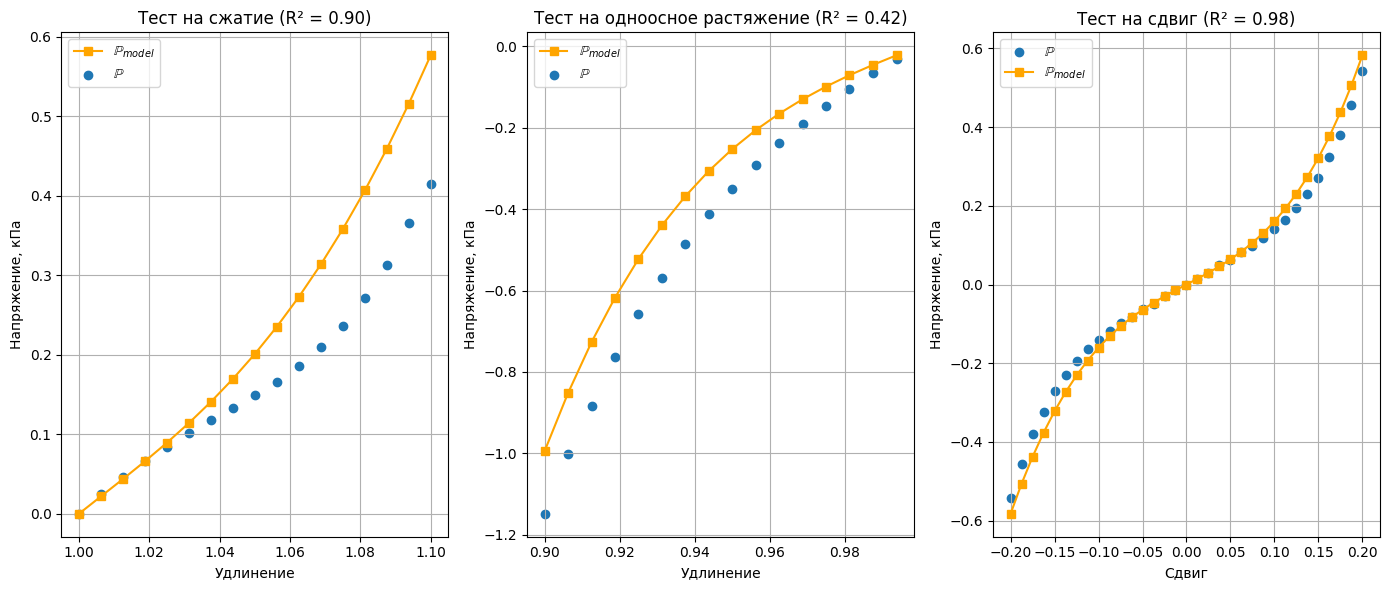

   stretch stress_ut   gamma stress_ss  weight_ut  weight_ss stress_ut_model  \
0      0.9   -1.1484    -0.2   -0.5435        0.5        1.0   [-0.99379516]   
1   0.9062   -1.0005 -0.1875   -0.4557        0.5        1.0    [-0.8522632]   
2   0.9125   -0.8837  -0.175   -0.3791        0.5        1.0   [-0.72634315]   
3   0.9187    -0.763 -0.1625   -0.3227        0.5        1.0    [-0.6181369]   
4    0.925   -0.6579   -0.15   -0.2698        0.5        1.0   [-0.52235997]   
5   0.9313   -0.5684 -0.1375   -0.2292        0.5        1.0   [-0.43922305]   
6   0.9375   -0.4866  -0.125   -0.1942        0.5        1.0    [-0.3682667]   
7   0.9437   -0.4127 -0.1125   -0.1649        0.5        1.0   [-0.30673528]   
8     0.95   -0.3504    -0.1   -0.1412        0.5        1.0   [-0.25259602]   
9   0.9563    -0.292 -0.0875   -0.1186        0.5        1.0    [-0.2057209]   
10  0.9625   -0.2375  -0.075   -0.0983        0.5        1.0   [-0.16561532]   
11  0.9688   -0.1908 -0.0625   -0.0814  

In [54]:
# experiments=[["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Compression"]
# experiments = ["Tensile", "Comression", "Shear"]
# models = [StrainEnergyCANN_C, StrainEnergyCANN_polinomial3]
models = [CANN_CombinedModel]
path = r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models\brain_CANN_CombinedModel\20240624_1604_1557.pth"
for model in models:


    # for idx, experiment in enumerate(experiments):
        # train_data_loader, test_data_loader = init_loaders(None)
        name = "brain_" + str(model.__name__)
        print("----------------------------------------------------------------------")
        # print(experiment)
        test_train = Trainer(
            plot_valid=False,
            epochs=10000,
            experiment_name=name,
            l2_reg_coeff=0.001,
            l1_reg_coeff=0.001,
            learning_rate=0.001,
            checkpoint=path,
            model=model,
            
            # dtype = torch.float64
        )
        
        trained_model = test_train.train(train_data_loader, None, weighting_data=True, train_mode="multiple_mode")
    
        trained_model.eval()
        vpredictions_ut = []
        vpredictions_ss = []
        vtargets = []
        for data in test_data_loader:
            stretch, gamma, stress_ut, stress_ss, weight_ut, weight_ss  = data
            stress_ut_model, stress_ss_model = trained_model(stretch, gamma)
            stress_ut_model = stress_ut_model.detach().numpy() 
            stress_ss_model = stress_ss_model.detach().numpy() 
            vpredictions_ut.append(stress_ut_model)
            vpredictions_ss.append(stress_ss_model)
        print(trained_model.get_potential())
        
        brain_data["stress_ut_model"] = vpredictions_ut
        brain_data["stress_ss_model"] = vpredictions_ss
        plot_results(brain_data)
        # combined_data.to_csv(os.path.join(os.path.join(path, str(name)), "data.csv"))
        # brain_data.pop("stress_ut_model_" + name)
        # brain_data.pop("stress_ss_model_" + name)

print(brain_data)
# trained_model = StrainEnergyCANN_C()

# print("R2:", r2_score_own(vtargets, vpredictions))
# plt.figure(figsize=(10, 5))
# plt.plot(vpredictions, label='P_pred', color='red')
# plt.plot(vtargets, label='P_true', color='black')
# plt.xlabel('lambda/gamma')
# plt.ylabel('P')
# plt.title('Predictions vs. Targets')
# plt.legend()

plt.show()

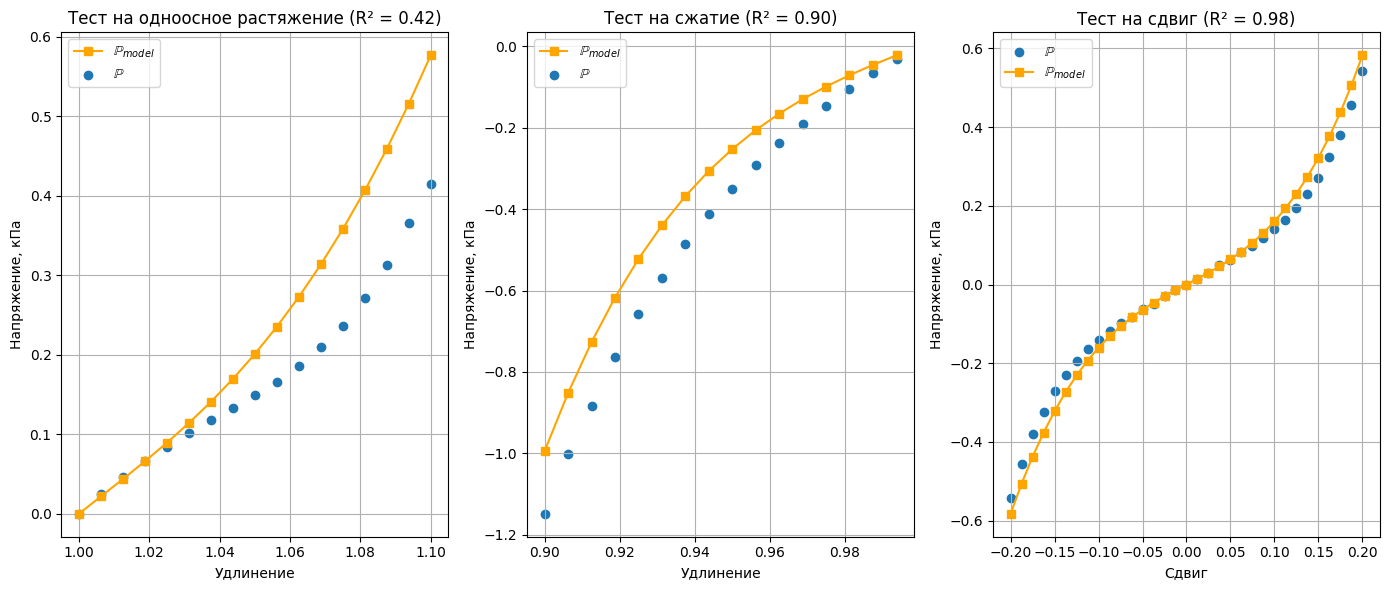

(0.8999957526155198, 0.8999957526155198, 0.9821706070726224)

In [58]:
plot_results(brain_data)


# GPT